# Project report: Hourly Rate Prediction

author: Raphael Riege <br>
date: 2022-12-01

### Aim
The aim of this project is to predict hourly rates of IT freelancers based on job titles, gender and skills. This should help to orient on an emerging job market and gives insights on what hourly rates depend. First, it is a reference point for finding an appropriate hourly rate given a the job title and the specific skill set. Second, it helps IT freelancers to decide which skills they should learn, and which field is the most profitable. Third, it shows weather gender plays a role regarding wages in IT freelancer market.

### Research question
Is it possible to predict hourly rates given a specific skillset, the job title(s), and the gender of an IT freelancer?

## 1 Preprocessing

In [1]:
# import modules
import random
import pandas as pd
from pandas.core.common import SettingWithCopyWarning
import warnings
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
import json
import numpy as np
from sklearn.model_selection import train_test_split 
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import validation_curve
from sklearn import  cluster
from sklearn.ensemble import RandomForestRegressor
%matplotlib inline
import matplotlib.pyplot as plt

## 1.1 Data import
The data was collected and provided by the *OptoPred* project of Universität Kassel and represents IT freelancers in the DACH region. It contains three data sets:
1. a dataset of IT freelancers, their reported hourly rate, gender, and job title(s);
2. a dataset of IT skills (represented by codes) that the freelancers of data set (1.) stated to have;
3. a codebook for the IT skills of data set (2.), so that you can assign a label to the skill codes.

In [2]:
# read data
hrate_df = pd.read_csv("../data_import/freelancer_tgr.csv", sep = ";", decimal = ",", encoding ='unicode_escape')
skills = pd.read_csv("../data_import/freelancer_skills.csv", sep = ";", decimal = ",")
codebook = pd.read_csv("../data_import/skill_codebook.csv", sep = ";", decimal = ",", encoding ='unicode_escape')

**Data set (1.) IT freelancers:**

In [3]:
# examples of hrate_df
hrate_df

,ref_id,Title,Gender,Hourly_Rate
0,96032,['business-intelligence'],male,93.145424
1,202714,['UNKNOWN'],unknown,40.000000
2,209323,['UNKNOWN'],male,NaN
3,92856,['it-projektmanag'],male,127.400000
4,112981,['system-admin'],male,75.000000
...,...,...,...,...
9867,42857,['UNKNOWN'],unknown,39.000000
9868,101664,['UNKNOWN'],female,120.000000
9869,125033,['UNKNOWN'],male,85.000000
9870,154699,['UNKNOWN'],male,NaN


The dataset 'hrate_df' consists of 9,872 IT freelancers (identifiable by ref_id), their stated job title(s), gender, and hourly rate. 

**Data set (2.) Skills:**

In [4]:
skills

,Unnamed: 0,I11_216,I0_7_14,I14_285_718,I12_229,B19_315_759,I11_216_589,I0_7_14_27,Ind0,B19_315,...,B5_121,I15_344_926,I4_102_349,B11_203_359,I14_294_759_209,B23_350_933,I15_385_1182,I4_108_381,I6_134,I15_385_1165
0,96032,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,202714,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,209323,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,92856,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,112981,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9867,42857,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9868,101664,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9869,125033,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9870,154699,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
skills = skills.rename(columns={"Unnamed: 0": "ref_id"})
skills = skills.fillna(0)
skills

,ref_id,I11_216,I0_7_14,I14_285_718,I12_229,B19_315_759,I11_216_589,I0_7_14_27,Ind0,B19_315,...,B5_121,I15_344_926,I4_102_349,B11_203_359,I14_294_759_209,B23_350_933,I15_385_1182,I4_108_381,I6_134,I15_385_1165
0,96032,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,202714,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,209323,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,92856,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,112981,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9867,42857,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9868,101664,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9869,125033,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9870,154699,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


The dataset 'skills' contains IT freelancers in the rows (N = 9872) and skill codes in the columns (k =  3231). The unnamed column corresponds to the 'ref_id' and is renamed accordingly. If a skill is present, the cell contains a 1. Otherwise, the cell contains a NaN. For simplicity, NaNs are replaced with zeros.

## 1.2 Data exploration and preparation
### 1.2.1 Hourly Rate
At first I inspect the the distribution of the hourly rates and especially the edges of the distribution to find and exclude outliers / unrealistic values.

Before preprocessing
Mean Hrate: 88.32183848566032
Min Hrate: 0.12419389800000001
Max Hrate: 1000.0
# NaN: 3519


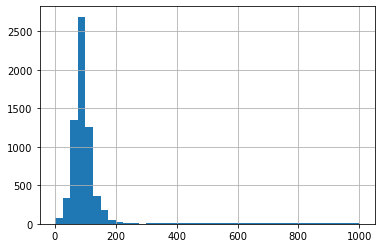

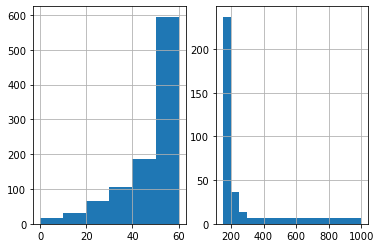

In [6]:
# Hourly Rate

print('Before preprocessing')
print('Mean Hrate:', hrate_df['Hourly_Rate'].mean())
print('Min Hrate:', hrate_df['Hourly_Rate'].min())
print('Max Hrate:',hrate_df['Hourly_Rate'].max())
print('# NaN:',hrate_df['Hourly_Rate'].isnull().sum())


hrate_df['Hourly_Rate'].hist(bins=[0, 25, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300, 1000])

fig, axes = plt.subplots(1, 2)

hrate_df['Hourly_Rate'].hist(bins=[0, 10, 20, 30, 40, 50, 60], ax=axes[0])
hrate_df['Hourly_Rate'].hist(bins=[150, 200, 250, 300, 1000], ax=axes[1])

In [7]:
# Process 'Hourly_Rate'

hrate_df = hrate_df.loc[(hrate_df['Hourly_Rate'] <= 200) & (hrate_df['Hourly_Rate'] >= 50)]

print('After preprocessing:')
pd.DataFrame(hrate_df['Hourly_Rate'].describe().round(2))

After preprocessing:


,Hourly_Rate
count,5907.00
mean,90.85
std,25.32
min,50.00
25%,75.00
50%,85.00
75%,100.00
max,200.00


Cases with hourly rates higher than 200 and lower than 50 are excluded because they seem to be outliers that would bias the prediction. The 3,519 NaN cases are also excluded in the process. Afterwards N equals to 5,907.

### 1.2.2 Gender
Gender / sex is represented by the categories 'andy', 'unknown', 'mostly_female', 'female', 'mostly_male', and 'male'. These categories come from an algorithm that assigns gender based on people first names. Therefore, in many cases there is no clear assignment to 'male' or 'female'. To simplify the analysis 'andy' and 'unknown' are treated as NaNs, 'mostly_female' as 'female' and 'mostly_male' as 'male'. Moreover I dummy code 'Gender' as 'Female' (True/False) for analysis purposes.

In [8]:
# Gender

print('Before recoding')
print(hrate_df.groupby('Gender').agg({'Hourly_Rate': ['mean', 'count']}))

hrate_df['Gender'] = hrate_df['Gender'].replace('andy', 'unknown')
hrate_df['Gender'] = hrate_df['Gender'].replace('mostly_female', 'female')
hrate_df['Gender'] = hrate_df['Gender'].replace('mostly_male', 'male')
hrate_df['Gender'] = hrate_df['Gender'].replace('unknown', np.NaN)

hrate_df.groupby('Gender').agg({'Hourly_Rate': ['mean', 'count']})
d = {'female': True, 'male': False}
hrate_df['Female'] = hrate_df['Gender'].map(d)
hrate_df_prep = hrate_df.drop(columns = 'Gender')

print('------------------------------------')
print('After recoding')
print(hrate_df_prep.groupby('Female').agg({'Hourly_Rate': ['mean', 'count']}))
print('# NaN:',hrate_df['Female'].isnull().sum())

Before recoding
              Hourly_Rate      
                     mean count
Gender                         
andy            72.333333    12
female          87.502372   478
male            91.659002  3589
mostly_female   87.252723     6
mostly_male     85.490754    49
unknown         90.413912  1773
------------------------------------
After recoding
       Hourly_Rate      
              mean count
Female                  
False    91.575922  3638
True     87.499277   484
# NaN: 1785


### 1.2.3 Job titles
One freelancer can have multiple job titles. Therefore I need to one-hot-encode job titles. Job titles that are 'UNKNOWN' or have too less observations like 'blockchain', 'sharepoint-develop' and 'ruby' are excluded to not bias the prediction.

In [9]:
#JobTitle
all_titles = [x for x in set(hrate_df['Title']) if "," not in x]
all_titles = [x.replace('[\'', '') for x in all_titles]
all_titles = [x.replace('\']', '') for x in all_titles]


def find_title(title):
    for jp in hrate_df['Title']:
        if title in jp:
            yield True
        else:
            yield False

jobtitles = [list(find_title(at)) for at in all_titles]      
jobtitles = pd.DataFrame(jobtitles).transpose()
jobtitles.columns = all_titles

print(jobtitles.sum().sort_values())
# blockchain, sharepoint-develop and ruby have no enough obs
# also drop UNKNOWN
jobtitles_one_hot = jobtitles.drop(columns=['blockchain', 'sharepoint-develop', 'ruby', 'UNKNOWN'])

blockchain                  4
ruby                        5
sharepoint-develop          9
database-admin             15
salesforce-develop         18
data-engin                 19
dynamics                   21
sap-basis                  23
python-develop             33
security-cons              44
android-develop            45
ios-develop                46
system-admin               59
business-intelligence      64
data-scien                 64
c++-develop                67
ux-design                  71
front end-develop          92
sap-develop               100
product-owner             105
php-develop               107
dev-ops                   120
c#-develop                122
business-analyst          151
net-develop               171
aws                       179
test-manag                182
scrum-master              214
sap-consult               259
java-develop              289
projekt-leit              442
it-projektmanag           875
UNKNOWN                  3070
dtype: int

Many job titles are unknown. The most frequent job titles are IT project manager, project leader, and java developer. The columns of blockchain, ruby and sharepoint developer are excluded because they contain less than 10 observations. In the next step I concatenate the one-hot-encoded jobtitles with the relevant columns of 'hrate_df_prep'.

In [10]:
# concat relevant cols of hrate_df_prep with one-hot-encoded jobtitles 

analytics_df = pd.concat(
    [hrate_df_prep[['ref_id', 'Female', 'Hourly_Rate']].reset_index(drop=True), 
     jobtitles_one_hot.reset_index(drop=True)], axis=1)


print(analytics_df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5907 entries, 0 to 5906
Data columns (total 32 columns):
ref_id                   5907 non-null int64
Female                   4122 non-null object
Hourly_Rate              5907 non-null float64
c++-develop              5907 non-null bool
database-admin           5907 non-null bool
product-owner            5907 non-null bool
ios-develop              5907 non-null bool
java-develop             5907 non-null bool
net-develop              5907 non-null bool
data-scien               5907 non-null bool
scrum-master             5907 non-null bool
salesforce-develop       5907 non-null bool
python-develop           5907 non-null bool
sap-develop              5907 non-null bool
ux-design                5907 non-null bool
business-analyst         5907 non-null bool
android-develop          5907 non-null bool
dev-ops                  5907 non-null bool
dynamics                 5907 non-null bool
it-projektmanag          5907 non-null bool
sap-bas

### 1.2.3 Skills
The skills dataset contains 3,230 skill codes. This is a very large number of features for an analysis. At the same time, certain skills are only represented very rarely. These should therefore be excluded. To find an appropriate minimum number, the skill frequencies are visualized.

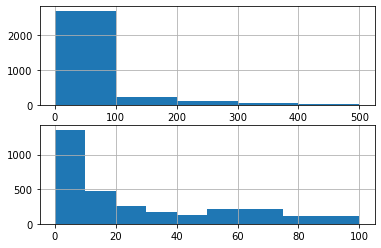

In [11]:
skillsum = skills.sum()
del skillsum['ref_id']

fig, axes = plt.subplots(2, 1)

skillsum.hist(bins=[0, 100, 200, 300, 400, 500],  ax=axes[0])
skillsum.hist(bins=[0, 10, 20, 30, 40, 50, 75, 100],  ax=axes[1])

skill_selector = list(skillsum[skillsum > 10].index)
skills_selected = skills[skill_selector]

A frequency of more than 10 cases seems appropriate. Therefore, skills that occur less frequently are excluded.

## 2. Analysis

### 2.1 Analysis with jobtitles and gender
In a first linear regression the hourly rate is predicted by jobtitles and gender. Then the model coefficients are inspected. For testing a random sample of 15 % of the cases is used.

In [12]:
# Filter Nas
analytics_df_v1 = analytics_df.loc[analytics_df['Female'].isna() == False]

# Split
xTrain_v1, xTest_v1, yTrain_v1, yTest_v1 = train_test_split(analytics_df_v1.drop(columns=['Hourly_Rate', 'ref_id']), #pred 
                                                analytics_df_v1['Hourly_Rate'], # regressand
                                                test_size=0.15, # 15% of the samples for testing
                                                random_state=42) 
# Model definition
linModel_v1 = linear_model.LinearRegression()
linModel_v1.fit(X=xTrain_v1.values, y=yTrain_v1.values)

# The model's coefficients
coeff_df = pd.DataFrame(linModel_v1.coef_, xTrain_v1.columns, columns=['Coefficient'])
print(coeff_df.sort_values('Coefficient'))


                       Coefficient
system-admin            -16.784751
front end-develop       -10.968929
php-develop              -9.444954
net-develop              -7.989393
ios-develop              -7.330212
ux-design                -7.020214
python-develop           -6.533057
java-develop             -6.354700
database-admin           -5.171054
c++-develop              -5.075546
test-manag               -4.107077
Female                   -3.857346
c#-develop               -3.262460
product-owner            -2.215763
android-develop          -0.515780
sap-basis                 1.001972
data-scien                1.582081
aws                       3.843286
data-engin                3.895605
sap-develop               3.896566
salesforce-develop        4.561080
business-intelligence     5.382199
business-analyst          5.498608
projekt-leit              5.621290
dev-ops                   6.810672
dynamics                  7.315681
it-projektmanag          11.661554
sap-consult         

The coefficients show which jobprofiles have a hourly rate above average (e.g. Security Consultant, Scrum Master, SAP Consultant and IT Project Manager) and which jobprofiles have a hourly rate below average (e.g. System Admins, Frontend, PHP, .NET or iOS Developer). Furthermore, being female has an negative effect as well. <br>
In the next step I test the model. For this purpose I also use crossvalidation.

In [13]:
# Test the model
y_predLin_v1 = linModel_v1.predict(xTest_v1.values)
pd.DataFrame({'Actual': yTest_v1, 'Predicted': y_predLin_v1})


print('Mean Absolute Error:', mean_absolute_error(yTest_v1.values, y_predLin_v1))
mseLin_v1 = mean_squared_error(yTest_v1.values, y_predLin_v1)
print('The Mean Squared Error = {0:.3f}'.format(mseLin_v1))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(yTest_v1.values, y_predLin_v1)))
r2_Lin_v1 = r2_score(yTest_v1.values, y_predLin_v1)
print('Goodness of Fit / R-Squared: {0:.3f}'.format(r2_Lin_v1))

# Crossvalidation
cv_score_v1 = cross_validate(linModel_v1, 
                analytics_df_v1.drop(columns=['Hourly_Rate', 'ref_id']), 
                analytics_df_v1['Hourly_Rate'], 
                scoring=["r2", "neg_mean_absolute_error", "neg_root_mean_squared_error"],
                cv=10)

print('Cross Validation scores:')
pd.DataFrame(pd.DataFrame(cv_score_v1).mean(), columns = ['mean_score'])

Mean Absolute Error: 17.931057598380796
The Mean Squared Error = 569.286
Root Mean Squared Error: 23.85971140811055
Goodness of Fit / R-Squared: 0.096
Cross Validation scores:


,mean_score
fit_time,0.025650
score_time,0.004561
test_r2,0.096596
test_neg_mean_absolute_error,-18.024264
test_neg_root_mean_squared_error,-24.231602


The R² is 0.096596, so 9.66% of the variance in the test set can be explained by the model. MAE is 18.02 and RMSE is 24.23.

### 2.2 Analysis with skills - no dimensionality reduction
Now the skills are to be included in the models. In order to not loose many cases I exclude the gender feature.

In [14]:
# no dimensionality reduction

analytics_df_v2 = pd.merge(analytics_df, 
                           pd.concat([skills['ref_id'].reset_index(drop=True), skills_selected], axis=1), 
                           'left')
analytics_df_v2

,ref_id,Female,Hourly_Rate,c++-develop,database-admin,product-owner,ios-develop,java-develop,net-develop,data-scien,...,I15_385_1171,I3_67_106,B4_106,I9,I15_344_997,I6_149_525,B11_203_307,B20_323_877,I14_300_831,I12_228_679
0,96032,False,93.145424,False,False,False,False,False,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,92856,False,127.400000,False,False,False,False,False,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,112981,False,75.000000,False,False,False,False,False,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,125158,False,75.000000,False,False,False,False,False,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,150672,False,65.000000,False,False,False,False,False,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5902,80785,False,60.000000,False,False,False,False,False,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5903,252671,False,85.000000,False,False,False,False,False,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5904,101664,True,120.000000,False,False,False,False,False,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5905,125033,False,85.000000,False,False,False,False,False,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
linModel_v2 = linear_model.LinearRegression()
cv_score_v2 = cross_validate(linModel_v2, 
                analytics_df_v2.drop(columns=['Hourly_Rate', 'ref_id', 'Female']), 
                analytics_df_v2['Hourly_Rate'],
                scoring=["r2", "neg_mean_absolute_error", "neg_root_mean_squared_error"],
                cv = 5)
print('Cross Validation scores:')
pd.DataFrame(pd.DataFrame(cv_score_v2).mean(), columns = ['mean_score'])

Cross Validation scores:


,mean_score
fit_time,9.076997
score_time,0.249305
test_r2,-0.377016
test_neg_mean_absolute_error,-22.272938
test_neg_root_mean_squared_error,-29.429000


As expected the validation scores are pretty bad. So the model does not fit well the test data. In the next models I use Ridge and Lasso regression. This should improve the performance because it uses L1 and L2 regularization so that unimportant features are penalized. This counteracts overfitting. 

In [16]:
reg_ridge = linear_model.Ridge()

cv_score_ridge = cross_validate(reg_ridge, 
                analytics_df_v2.drop(columns=['Hourly_Rate', 'ref_id', 'Female']), 
                analytics_df_v2['Hourly_Rate'],
                scoring=["r2", "neg_mean_absolute_error", "neg_root_mean_squared_error"],
                cv = 5)

print('Cross Validation scores:')
pd.DataFrame(pd.DataFrame(cv_score_ridge).mean(), columns = ['mean_score'])

Cross Validation scores:


,mean_score
fit_time,2.222719
score_time,0.266070
test_r2,-0.091306
test_neg_mean_absolute_error,-20.052517
test_neg_root_mean_squared_error,-26.276584


In [17]:
reg_lasso = linear_model.Lasso()

cv_score_lasso = cross_validate(reg_lasso, 
                analytics_df_v2.drop(columns=['Hourly_Rate', 'ref_id', 'Female']), 
                analytics_df_v2['Hourly_Rate'],
                scoring=["r2", "neg_mean_absolute_error", "neg_root_mean_squared_error"],
                cv = 5)
print('Cross Validation scores:')
pd.DataFrame(pd.DataFrame(cv_score_lasso).mean(), columns = ['mean_score'])


Cross Validation scores:


,mean_score
fit_time,2.144829
score_time,0.259245
test_r2,0.087205
test_neg_mean_absolute_error,-18.112466
test_neg_root_mean_squared_error,-24.142525


The validation scores of the ridge regressio are still pretty bad. Different from that, the lasso regression improves the performance. But it is still not better than the model without skills. So in the next models I use the dimensionality reduced dataframes.

### 2.3 Analysis with skills - supervised dimensionality reduction
The skill codes are already arranged hierarchically in a taxonomy. E.g. the skill code B1_1 is a child of B1 and B1_1_1 is a grandchild of B1. This can be used to reduce the dimensions of the analysis dataset. At first, I identify all top level skill codes which are the main skill categories. Then, for each of these main categories, I count how often child and grandchild skills appear in a row. This number is then divided by the number of child and grandchild skills so that all main categories have a value between 0 and 1. Finally, I concatenate all main categories into one data set.

In [18]:
# supervised dimensionality reduction
skillcodes = list(skills.columns) 

main_cat = []

for sc in skillcodes:
    if '_' not in sc:
        main_cat.append(sc)

def calc_sum_skillcat(skillcode):
    sel_cols = [col for col in skills.columns if skillcode + '_' in col]
    sel_cols.append(skillcode)
    return skills[sel_cols].sum(axis=1) / len(sel_cols)
    
sum_skillcat = [calc_sum_skillcat(sc) for sc in main_cat]
sum_skillcat = pd.concat(sum_skillcat, axis=1, keys = main_cat)
sum_skillcat = pd.concat([skills['ref_id'].reset_index(drop=True), sum_skillcat], axis=1)

sum_skillcat

,ref_id,Ind0,I12,B11,Ind36,Ind51,Ind1,B12,B5,Ind12,...,B28,Ind43,B30,B22,Ind14,I9,Ind13,I10,B34,Ind40
0,96032,1.0,0.028169,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.004016,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,202714,0.0,0.000000,0.021390,1.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,209323,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
3,92856,0.0,0.000000,0.000000,0.0,1.0,0.5,0.333333,0.052632,1.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
4,112981,0.0,0.056338,0.000000,0.0,0.0,0.0,0.000000,0.026316,0.0,...,0.0,0.0,0.004016,0.0,0.0,0.0,0.0,0.0,0.142857,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9867,42857,0.0,0.000000,0.010695,0.0,0.0,0.5,0.000000,0.026316,1.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
9868,101664,1.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.017544,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
9869,125033,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
9870,154699,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.061404,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


Now I use the main category dataset for regression. Therefore I merge the analytics dataframe with the main category datset. At first I train a model without the gender feature in order to exclude fewer cases. I then use this data set for a lasso and a ridge regression. Afterwards I repeat the analysis with the gender feature, excluding all cases with missings in gender. The models are evaluated again by cross-validation.

In [19]:
# supervised dimensionality reduction
##withot Gender

analytics_df_v3 = pd.merge(analytics_df, sum_skillcat, 'left')

xTrain_v3, xTest_v3, yTrain_v3, yTest_v3 = train_test_split(analytics_df_v3.drop(columns=['Hourly_Rate', 'ref_id', 'Female']), #pred 
                                                analytics_df_v3['Hourly_Rate'], # regressand
                                                test_size=0.15, # 15% of the samples for testing
                                                random_state=42) 

print('Training size:', len(yTrain_v3))
print('Test size:', len(yTest_v3))

linModel_v3 = linear_model.LinearRegression()
linModel_v3.fit(X=xTrain_v3.values, y=yTrain_v3.values)


# Test the model
y_predLin_v3 = linModel_v3.predict(xTest_v3.values)
#pd.DataFrame({'Actual': yTest_v3, 'Predicted': y_predLin_v3})


print('Mean Absolute Error:', mean_absolute_error(yTest_v3.values, y_predLin_v3))
mseLin_v3 = mean_squared_error(yTest_v3.values, y_predLin_v3)
print('The Mean Squared Error = {0:.3f}'.format(mseLin_v3))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(yTest_v3.values, y_predLin_v3)))
r2_Lin_v3 = r2_score(yTest_v3.values, y_predLin_v3)
print('Goodness of Fit / R-Squared: {0:.3f}'.format(r2_Lin_v3))
random.seed(10)
cv_score_v3 = cross_validate(linModel_v3, 
                analytics_df_v3.drop(columns=['Hourly_Rate', 'ref_id', 'Female']), 
                analytics_df_v3['Hourly_Rate'],
                scoring=["r2", "neg_mean_absolute_error", "neg_root_mean_squared_error"],
                cv=10)
print('Cross Validation scores:')
pd.DataFrame(pd.DataFrame(cv_score_v3).mean(), columns = ['mean_score'])


Training size: 5020
Test size: 887
Mean Absolute Error: 16.83078250046947
The Mean Squared Error = 527.621
Root Mean Squared Error: 22.970008008547286
Goodness of Fit / R-Squared: 0.152
Cross Validation scores:


,mean_score
fit_time,0.200967
score_time,0.012378
test_r2,0.187706
test_neg_mean_absolute_error,-16.856804
test_neg_root_mean_squared_error,-22.743154


In [20]:
# supervised dimensionality reduction
# Lasso
reg_lasso_v3 = linear_model.Lasso()
random.seed(10)
cv_score_lasso_v3 = cross_validate(reg_lasso, 
                analytics_df_v3.drop(columns=['Hourly_Rate', 'ref_id', 'Female']), 
                analytics_df_v3['Hourly_Rate'],
                scoring=["r2", "neg_mean_absolute_error", "neg_root_mean_squared_error"],
                cv = 5)
print('Cross Validation scores:')
pd.DataFrame(pd.DataFrame(cv_score_lasso_v3).mean(), columns = ['mean_score'])

Cross Validation scores:


,mean_score
fit_time,0.129878
score_time,0.023219
test_r2,0.016169
test_neg_mean_absolute_error,-18.889819
test_neg_root_mean_squared_error,-25.062970


In [21]:
# supervised dimensionality reduction
# Ridge
reg_ridge_v3 = linear_model.Ridge()
random.seed(10)
cv_score_ridge_v3 = cross_validate(reg_ridge, 
                analytics_df_v3.drop(columns=['Hourly_Rate', 'ref_id', 'Female']), 
                analytics_df_v3['Hourly_Rate'],
                scoring=["r2", "neg_mean_absolute_error", "neg_root_mean_squared_error"],
                cv = 5)

print('Cross Validation scores:')
pd.DataFrame(pd.DataFrame(cv_score_ridge_v3).mean(), columns = ['mean_score'])

Cross Validation scores:


,mean_score
fit_time,0.091653
score_time,0.020803
test_r2,0.180892
test_neg_mean_absolute_error,-16.890870
test_neg_root_mean_squared_error,-22.876667


In [22]:
# supervised dimensionality reduction
## with Gender

analytics_df_v3_2 = analytics_df_v3.loc[analytics_df_v3['Female'].isna() == False]

xTrain_v3_2, xTest_v3_2, yTrain_v3_2, yTest_v3_2 = train_test_split(
    analytics_df_v3_2.drop(columns=['Hourly_Rate', 'ref_id']), #pred
    analytics_df_v3_2['Hourly_Rate'], # regressand
    test_size=0.15, # 15% of the samples for testing
    random_state=42) 

print('Training size:', len(yTrain_v3_2))
print('Test size:', len(yTest_v3_2))

linModel_v3_2 = linear_model.LinearRegression()
linModel_v3_2.fit(X=xTrain_v3_2.values, y=yTrain_v3_2.values)


# Test the model
y_predLin_v3_2 = linModel_v3_2.predict(xTest_v3_2.values)
#pd.DataFrame({'Actual': yTest_v3_2, 'Predicted': y_predLin_v3_2})


print('Mean Absolute Error:', mean_absolute_error(yTest_v3_2.values, y_predLin_v3_2))
mseLin_v3_2 = mean_squared_error(yTest_v3_2.values, y_predLin_v3_2)
print('The Mean Squared Error = {0:.3f}'.format(mseLin_v3_2))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(yTest_v3_2.values, y_predLin_v3_2)))
r2_Lin_v3_2 = r2_score(yTest_v3_2.values, y_predLin_v3_2)
print('Goodness of Fit / R-Squared: {0:.3f}'.format(r2_Lin_v3_2))

random.seed(10)
cv_score_v3_2 = cross_validate(linModel_v3_2, 
                analytics_df_v3_2.drop(columns=['Hourly_Rate', 'ref_id']), 
                analytics_df_v3_2['Hourly_Rate'],
                scoring=["r2", "neg_mean_absolute_error", "neg_root_mean_squared_error"],
                cv=10)
print('Cross Validation scores:')
pd.DataFrame(pd.DataFrame(cv_score_v3_2).mean(), columns = ['mean_score'])


Training size: 3503
Test size: 619
Mean Absolute Error: 17.141824851816715
The Mean Squared Error = 517.354
Root Mean Squared Error: 22.74540834202203
Goodness of Fit / R-Squared: 0.178
Cross Validation scores:


,mean_score
fit_time,0.134337
score_time,0.010548
test_r2,0.194828
test_neg_mean_absolute_error,-17.032602
test_neg_root_mean_squared_error,-22.864781


Result: This procedure significantly improves the prediction quality. The linear model without gender has an R² of 0.1877, Lasso regression of 0.0162, and Ridge regression of 0.1809. The model with gender has the highest R² which is 0.1948.

### 2.4 Analysis with skills - unsupervised dimensionality reduction

Instead of supervised dimensionality reduction using skill codes, I now use an unsupervised dimensionality reduction procedure. Using the 'FeatureAgglomeration' algorithm, skill clusters are formed, which can also be used for prediction.

In [23]:
# unsupervised dimensionality reduction - cluster analysis

X_skills = skills.drop(columns=['ref_id'])
X_skills.shape

agglo = cluster.FeatureAgglomeration(n_clusters=32)
agglo.fit(X_skills)
X_skills_reduced = agglo.transform(X_skills)
X_skills_reduced.shape

(9872, 32)

In [24]:
pd.DataFrame(X_skills_reduced).head()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,0.016949,0.0,0.285714,0.5,1.0,0.25,0.000000,0.001409,0.0,0.0,...,0.086957,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.007463,0.0
1,0.000000,0.0,0.000000,0.0,0.0,0.00,0.285714,0.000705,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,0.000000,0.0,0.000000,0.0,0.0,0.00,0.000000,0.001057,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
3,0.067797,0.0,0.000000,0.0,0.0,0.00,0.000000,0.002467,0.0,0.0,...,0.000000,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.007463,0.0
4,0.016949,0.0,0.000000,0.5,0.0,0.00,0.000000,0.003171,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


In [25]:
analytics_df_v4 = pd.merge(analytics_df, 
                           pd.concat(
                               [skills['ref_id'].reset_index(drop=True), 
                                pd.DataFrame(X_skills_reduced)], 
                               axis=1), 
                           'left')
analytics_df_v4.head()

,ref_id,Female,Hourly_Rate,c++-develop,database-admin,product-owner,ios-develop,java-develop,net-develop,data-scien,...,22,23,24,25,26,27,28,29,30,31
0,96032,False,93.145424,False,False,False,False,False,False,False,...,0.086957,0.0,0.0,0.00,1.0,0.0,0.0,0.0,0.007463,0.0
1,92856,False,127.400000,False,False,False,False,False,False,False,...,0.000000,0.0,1.0,0.00,0.0,0.0,1.0,0.0,0.007463,0.0
2,112981,False,75.000000,False,False,False,False,False,False,False,...,0.000000,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.000000,0.0
3,125158,False,75.000000,False,False,False,False,False,False,False,...,0.000000,0.5,1.0,0.44,0.0,1.0,0.0,1.0,0.022388,0.0
4,150672,False,65.000000,False,False,False,False,False,False,False,...,0.000000,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.000000,0.0


In [26]:
linModel_v4 = linear_model.LinearRegression()
cv_score_v4 = cross_validate(linModel_v4, 
                analytics_df_v4.drop(columns=['Hourly_Rate', 'ref_id', 'Female']), 
                analytics_df_v4['Hourly_Rate'],
                scoring=["r2", "neg_mean_absolute_error", "neg_root_mean_squared_error"],
                cv = 5)
print('Cross Validation scores:')
pd.DataFrame(pd.DataFrame(cv_score_v4).mean(), columns = ['mean_score'])


Cross Validation scores:


,mean_score
fit_time,0.070295
score_time,0.010847
test_r2,0.180874
test_neg_mean_absolute_error,-16.941306
test_neg_root_mean_squared_error,-22.872427


The model quality is similar to the models with supervised dimensionality reduction. Since the number of skill clusters is a hyperparameter, the goal is to find out which cluster number achieves the best validation score. Models with 50, 100, 150, 200 and 250 clusters are fitted for this purpose.

In [27]:
def find_clustersize(size):
    X = skills.drop(columns=['ref_id'])
    agglo = cluster.FeatureAgglomeration(n_clusters=size)
    agglo.fit(X)
    X_reduced = agglo.transform(X)
    
    analytics_df_v4 = pd.merge(analytics_df, 
                           pd.concat(
                               [skills['ref_id'].reset_index(drop=True), 
                                pd.DataFrame(X_reduced)], 
                               axis=1), 
                           'left')
    linModel = linear_model.LinearRegression()
    cv_score = cross_validate(linModel, 
                analytics_df_v4.drop(columns=['Hourly_Rate', 'ref_id', 'Female']), 
                analytics_df_v4['Hourly_Rate'],
                scoring=["r2", "neg_mean_absolute_error", "neg_root_mean_squared_error"],
                cv = 10)
    
    print('Model with ' + str(size) + ' clusters fitted.')
    return pd.DataFrame(pd.DataFrame(cv_score).mean(), columns = [str(size) + ' cl_scores'])

In [28]:
clusterscores = [find_clustersize(s) for s in (50, 100, 150, 200, 250)]

Model with 50 clusters fitted.
Model with 100 clusters fitted.
Model with 150 clusters fitted.
Model with 200 clusters fitted.
Model with 250 clusters fitted.


In [29]:
eval_clusterscores = pd.concat(clusterscores, axis = 1)
eval_clusterscores

,50 cl_scores,100 cl_scores,150 cl_scores,200 cl_scores,250 cl_scores
fit_time,0.109953,0.193180,0.333092,0.357098,0.441661
score_time,0.008610,0.011994,0.019588,0.016280,0.022699
test_r2,0.187697,0.208704,0.221734,0.227046,0.227013
test_neg_mean_absolute_error,-16.927961,-16.736874,-16.622437,-16.539513,-16.551105
test_neg_root_mean_squared_error,-22.739199,-22.448978,-22.258094,-22.175856,-22.173453


Result: Using 200 clusters the R² is 0.2271 and thus the highest. Now I want to test if the R² increases if I add the gender feature.

In [30]:
# with gender
X = skills.drop(columns=['ref_id'])
agglo = cluster.FeatureAgglomeration(n_clusters=200)
agglo.fit(X)
X_reduced = agglo.transform(X)

analytics_df_v4_2 = pd.merge(analytics_df, 
                       pd.concat(
                           [skills['ref_id'].reset_index(drop=True), 
                            pd.DataFrame(X_reduced)], 
                           axis=1), 
                       'left')
analytics_df_v4_2 = analytics_df_v4_2.loc[analytics_df_v4_2['Female'].isna() == False]
linModel_v4_2 = linear_model.LinearRegression()
cv_score_v4_2 = cross_validate(linModel_v4_2, 
                analytics_df_v4_2.drop(columns=['Hourly_Rate', 'ref_id']), 
                analytics_df_v4_2['Hourly_Rate'],
                scoring=["r2", "neg_mean_absolute_error", "neg_root_mean_squared_error"],
                cv = 10)

print('Cross Validation scores:')
pd.DataFrame(pd.DataFrame(cv_score_v4_2).mean(), columns = ['mean_score'])

Cross Validation scores:


,mean_score
fit_time,0.261219
score_time,0.016280
test_r2,0.219743
test_neg_mean_absolute_error,-16.880604
test_neg_root_mean_squared_error,-22.506480


Result: The R² does not increase.

### 2.5 Random Forest

I now use the same data set with 200 clusters within a random forest model. These are suitable for regression tasks with many features.

In [31]:
# best dim reduction

agglo = cluster.FeatureAgglomeration(n_clusters=200)
agglo.fit(X_skills)
X_skills_reduced_best = agglo.transform(X_skills)

analytics_df_v5 = pd.merge(analytics_df, 
                           pd.concat(
                               [skills['ref_id'].reset_index(drop=True), 
                                pd.DataFrame(X_skills_reduced_best)], 
                               axis=1), 
                           'left')
analytics_df_v5.shape

(5907, 232)

In [32]:
rf = RandomForestRegressor(n_estimators = 500, random_state = 42)
cv_score_rf = cross_validate(rf, 
                analytics_df_v5.drop(columns=['Hourly_Rate', 'ref_id', 'Female']), 
                analytics_df_v5['Hourly_Rate'],
                scoring=["r2", "neg_mean_absolute_error", "neg_root_mean_squared_error"],
                cv = 10, 
                verbose = 2)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[CV] ................................................. , total= 2.3min
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.3min remaining:    0.0s


[CV] ................................................. , total= 2.4min
[CV]  ................................................................
[CV] ................................................. , total= 2.7min
[CV]  ................................................................
[CV] ................................................. , total= 2.7min
[CV]  ................................................................
[CV] ................................................. , total= 2.4min
[CV]  ................................................................
[CV] ................................................. , total= 2.3min
[CV]  ................................................................
[CV] ................................................. , total= 3.3min
[CV]  ................................................................
[CV] ................................................. , total= 3.1min
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 27.5min finished


In [33]:
pd.DataFrame(pd.DataFrame(cv_score_rf).mean(), columns = ['mean_score'])

,mean_score
fit_time,164.482621
score_time,0.257361
test_r2,0.235477
test_neg_mean_absolute_error,-16.339342
test_neg_root_mean_squared_error,-22.058620


In [34]:
# Instantiate model with 500 decision trees
rf = RandomForestRegressor(n_estimators = 500, random_state = 42)

X_rf = analytics_df_v5.drop(columns=['Hourly_Rate', 'ref_id', 'Female'])
y_rf = analytics_df_v5['Hourly_Rate']
                                

# Train the model on training data
rf.fit(X_rf, y_rf)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=500, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

Result: With an R² over 23% this model quality is the highest. So I am gonna use it beside the linear model with 200 skillclusters for prediction

## 3 Prediction

Lastly, I want to use the best performing models to predict my own hourly rate. This serves as a final test and should show which steps are necessary to predict values in practice.

In [35]:
X_rf = analytics_df_v5.drop(columns=['Hourly_Rate', 'ref_id', 'Female'])
y_rf = analytics_df_v5['Hourly_Rate']

linModel_pred = linear_model.LinearRegression()
linModel_pred.fit(X=X_rf.values, y=y_rf.values)

y_predLin = linModel_pred.predict(X_rf.values)
y_predLin
X_rf.values.shape

(5907, 229)

I use "Data Scientist" as the job title and create a row of a one-hot-encoded data frame with all job titles matching the structure of the analysis data.

In [36]:
# Jobtitle
own_jt = "data-scien"
own_jt_df = pd.DataFrame({'own' : own_jt == jobtitles_one_hot.columns},
            index = jobtitles_one_hot.columns).transpose()

In [37]:
# skills

The skills must also fit the structure of the analysis data. For this purpose, I first save my skills in normal notation in a list. Then I join this list with the codebook to get the skill codes.

In [38]:
codebook

,name_en,name_ger,skill_code
0,Database Systems,Datenbankensysteme,I0
1,Automotive Tools,Automotive Tools,I1
2,Internet der Dinge,Internet of Things,I2
3,Software Development,Softwareentwicklung,I3
4,IT Security,IT Security,I4
...,...,...,...
5337,GPM,GPM,Cert0_75_9_0
5338,IPMA Level C,IPMA Level C,Cert0_75_9_1
5339,IPMA Level D,IPMA Level D,Cert0_75_9_2
5340,PMP,PMP,Cert0_75_13_3


In [39]:
own_skills = ["Datenanalyse",
              "Datenvisualisierung",
              "R (programming language)",
              "Data Science",
              "Tidyverse",
              "Datenmanagement",
              "ggplot2",
              "R Markdown",
              "Statistik",
              "Projektmanagement",
              "Content-Management",
              "Predictive Analytics",
              "Data Mining",
              "Microsoft Office",
              "Online-Marketing",
              "Scrum",
              "Shiny",
              "Ökonometrie",
              "Marketing",
              "Softwareentwicklung",
              "Datenbankensysteme",
              "Internet und Informationstechnologie (Branche)",
              "Wissenschaft (Branche)",
              "NumPy",
              "JIRA",
              "Datenmodellierung",
              "Python",
              "Big Data",
              "Git",
              "quantitative Marktforschung",
              "SAP Analytics Cloud",
              "Marketingstatistik",
              "Marktforschung",
              "Advanced Analytics",
              "User Stories",
              "Business Intelligence",
              "Confluence",
              "Highcharts",
              "Stata",
              "BPMN",
              "Typo3",
              "SQL",
              "HTML",
              "Wordpress",
              "Maschinelles Lernen",
              "TensorFlow",
              "Scikit-Learn",
              "Deep Learning",
              "Data Engineering",
              "Prozessanalyse",
              "Pandas",
              "Flask",
              "Keras"]
own_df = pd.DataFrame({'name_ger' : own_skills})
own_df = pd.merge(own_df, codebook, 'left')
own_df

,name_ger,name_en,skill_code
0,Datenanalyse,Data Analysis,I11
1,Datenvisualisierung,Data Visualization,I11_219
2,R (programming language),R (Programmiersprache),I15_414
3,Data Science,Data Science,I11_223
4,Tidyverse,Tidyverse,I15_414_1246
5,Datenmanagement,Data Management,I0_10
6,ggplot2,ggplot2,I15_414_1241
7,R Markdown,R Markdown,I15_414_1244
8,Statistik,Statistics,I11_203
9,Projektmanagement,Project Management,B5


Now I one-hot-encode the skills and transform them to a data set in wide format. This skill data set is used for feature reduction according to the procedure of the analytics data.

In [40]:
myskills_onehot = []
for x in list(X_skills.columns):
    skill_av = x in list(own_df['skill_code'])
    myskills_onehot.append(skill_av)

myskills_df = pd.DataFrame({'own' : myskills_onehot},
             index = X_skills.columns).transpose()

myskills_trans = agglo.transform(myskills_df)

I now concatenate the dimension-reduced dataset with the job profile dataset so that the resulting dataset can be used for prediction. As models I use a linear model and a random forest model.

In [41]:
x_own = pd.concat([own_jt_df.reset_index(drop=True), pd.DataFrame(myskills_trans).reset_index(drop=True)], axis=1)

pd.DataFrame({"model" : ["linear model", "random forest"],
             "predicted value": [linModel_pred.predict(x_own), rf.predict(x_own)]})

,model,predicted value
0,linear model,[84.7335811927044]
1,random forest,[90.2747715811]


Result: The prediction worked and the predicted values seem to be adequate.

## 4 Discussion

**Summary** <br>
In this project, a large amount of real data from freelancers was analyzed to predict hourly rates. Explanatory variables include job profiles, gender, and skills. All of these predictors contributed to the prediction. It was analyzed which job profiles have a positive and which have a negative effect on the hourly rate. Furthermore, I showed that female gender also has a negative effect on IT freelancers. Using the job titles and gender, I was able to achieve a variance explanation of about 10%. A significant improvement was achieved by adding the skills. Here it proved useful to reduce the high number of dimensions. Both supervised dimensionality reduction and unsupervised agglomeration more than doubled explained variance. Using a linear model and a random forest with 200 skill clusters, a robust hourly rate prediction can be made. 
This approach with a wide number of skills and job tiles is extremely innovative and an hourly rate prediction of this kind can become a very useful tool for an increasing number of IT freelancers.

**Challenges** <br>
The biggest challenge was to process the large number of features. Especially the number of skills had to be reduced by different methods. Another challenge was the large number of NaNs for gender. This resulted in many cases having to be excluded when gender was included. The situation was similar for job profiles. Here, some cases had to be excluded to avoid biasing the estimate. Overall, a lot of data preparation was necessary to obtain suitable analysis data sets.

**Limitations** <br>
The quality of the prediction is solid, but can be improved. Approximately 80% of the variance remains unexplained. Furthermore, biases cannot be completely excluded. For example, certain job titles and skills are significantly underrepresented, making estimates for rare skills and job titles less reliable.

**Outlook** <br>
More data can be collected to improve the prediction. I suspect, for example, that experience level and skill level are exceedingly relevant to hourly rate. Another predictor may be prior project experience. All together this may lead to an accurate prediction.